<a href="https://colab.research.google.com/github/Selva-Subramanian/Zomato-restaurant-clustering-Sentiment-Analysis/blob/main/ZOMATO_RESTAURANT_CLUSTERING_AND_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [5]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b> Importing the required libraries

In [118]:
# for numerical computation
import numpy as np
from operator import add
import math
# for data manipulation 
import pandas as pd
# for creating copies
import copy

# for plotting visuals
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# for ease of view
from google.colab import data_table
data_table.enable_dataframe_formatter()

# data analysis
from wordcloud import WordCloud
from prettytable import PrettyTable
# scaling the dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model building
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

# evaluation metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix, classification_report

# natural language processing
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
# load the dataset
working_dir_path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Zomato Restaurant Analysis and Sentiment Analysis - Selva Subramanian S/'
df1 = pd.read_csv(working_dir_path + 'Zomato Restaurant names and Metadata.csv')
df2 = pd.read_csv(working_dir_path + 'Zomato Restaurant reviews.csv')

### <b> Data Inspection

In [120]:
# sample of the dataset
df1.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [121]:
# brief info of the dataset 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [122]:
# brief description of the dataset
pd.set_option('display.max_rows', None)
df1.describe()

,Name,Links,Cost,Collections,Cuisines,Timings
count,105,105,105,51,105,104
unique,105,105,29,42,92,77
top,GD's,https://www.zomato.com/hyderabad/frio-bistro-g...,500,Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,4,6


In [123]:
# columns in the datset
df1.columns

Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

#### All restaurants have links and it is not much useful so let's just drop it. 


In [124]:
# Drop columns
df1 = df1.drop(['Links'], axis=1)

In [125]:
# replace null values with a string
df1 = df1.fillna('no info')
df1['Timings'][30] = 'no info'

In [126]:
# change datatype of 'Cost' feature
df1['Cost'] = df1['Cost'].apply(lambda x: int(x.replace(',','')))

In [127]:
# formatting the string in  Timings feature
word_list = [[['noon','Noon','PM','pm'],['p.m.']],[['midnight','Midnight','AM','am'],['a.m.']]]
for i in word_list:
  j = i[1][0]
  for k in i[0]:
    df1['Timings'] = df1['Timings'].str.replace(k,j)

### <b> Exploratory Data Analysis

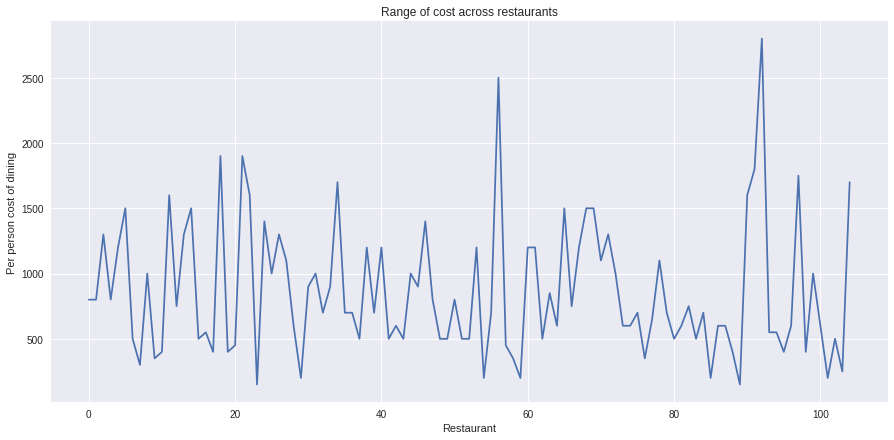

min: 150.0
IQR1: 500.0
avg: 700.0
IQR3: 1200.0
max: 2800.0


In [128]:
# Analysis of the feature 'Cost'
plt.figure(figsize=(15,7))
df1['Cost'].plot(kind='line')
plt.title("Range of cost across restaurants")
plt.xlabel("Restaurant")
plt.ylabel("Per person cost of dining")
plt.show()
print(f"min: {df1['Cost'].describe()[3]}\nIQR1: {df1['Cost'].describe()[4]}\navg: {df1['Cost'].describe()[5]}\nIQR3: {df1['Cost'].describe()[6]}\nmax: {df1['Cost'].describe()[7]}")

#### Most of the restaurants cost of dining per person lies in the range of 500 and 1200 with minimum cost of dining per person at 150 and maximum at 2800 and average cost at 700.

##### <b> Unique values in our features





In [129]:
# initialize empty lists
Unique_Collections = []
Unique_Cuisines = []

# features list
unique_list = [Unique_Collections, Unique_Cuisines]

# logic to extract unique values in the features
sum = 0
for i in df1.columns[2:-1]:
  l = unique_list[sum]
  sum += 1
  for j in range(len(df1[i])):
    for k in list(df1[i])[j].split(','):
      if k not in l and k[1:] not in l:
        if k[0]==' ':
          l.append(k[1:])
        else:
          l.append(k)

# number of unique items in the features
print(f"Total unique values in the feature 'Cost' is {len(df1['Cost'].value_counts())}\n")
for n,m in enumerate(df1.columns[2:-1]):
  print(f"Total unique values in the feature '{m}' is {len(unique_list[n])}\n")

Total unique values in the feature 'Cost' is 29

Total unique values in the feature 'Collections' is 38

Total unique values in the feature 'Cuisines' is 44



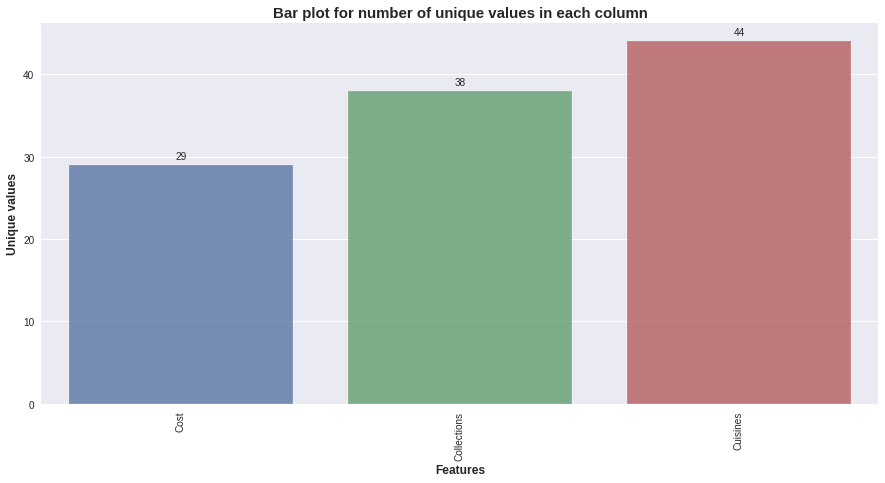

In [130]:
#Counting unique value of features
feature_names = ['Cost', 'Collections', 'Cuisines']
cost = len(df1['Cost'].value_counts())
collections = len(unique_list[0])
cuisines = len(unique_list[1])
feature_count = [cost, collections, cuisines]
f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=feature_names, y=feature_count, alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [131]:
import numpy as np
a = np.array([1,2,3,4])
np.reshape(a,(2,2))

array([[1, 2],
       [3, 4]])

In [132]:
# count of unique items in the features
features = ['Collections', 'Cuisines']

# initialize empty dictionaries
unique_count = {}
m = {}

# update unique values of 'Cost' and its frequency of occurence
for l in df1['Cost'].unique():
  m[l] = list(df1['Cost'].values).count(l)
unique_count['Cost'] = m
sum = 0

# initialize empty lists
collections_feature_list = []
cuisines_feature_list = []

# update unique values of 'Collections' and 'Cuisines' 
for i in unique_list:
  if i == unique_list[0]:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: collections_feature_list.extend(x))
    collections_feature_list = [x[1:] if x[0]==' ' else x[:] for x in collections_feature_list]
  else:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: cuisines_feature_list.extend(x))
    cuisines_feature_list = [x[1:] if x[0]==' ' else x[:] for x in cuisines_feature_list]
  
  # empty dict for 'Collections' and 'Cuisines'
  k = {}
  # update frequency of occurence
  for j in i:
    if i == unique_list[0]:
      k[j] = collections_feature_list.count(j)
    else:
      k[j] = cuisines_feature_list.count(j)  
  unique_count[features[sum]] = k
  feature_list = []
  sum += 1  

#### *Top 25 most frequent values of the features*

In [133]:
# create a table for a better visual
table = PrettyTable(['SL', 'Cost', 'Collections', 'Cuisines'])
for i in range(1,26):
  table.add_row([i, sorted(unique_count['Cost'].items(), key=lambda x: x[1],reverse = True)[i], sorted(unique_count['Collections'].items(), key=lambda x: x[1], reverse = True)[i], sorted(unique_count['Cuisines'].items(), key=lambda x: x[1], reverse = True)[i]])
table

SL,Cost,Collections,Cuisines
1,"(600, 10)","('Great Buffets', 11)","('Chinese', 43)"
2,"(700, 8)","('Food Hygiene Rated Restaurants in Hyderabad', 8)","('Continental', 21)"
3,"(1200, 7)","('Live Sports Screenings', 7)","('Biryani', 16)"
4,"(1000, 6)","(""Hyderabad's Hottest"", 7)","('Asian', 15)"
5,"(400, 6)","('Corporate Favorites', 6)","('Fast Food', 15)"
6,"(800, 5)","('Top-Rated', 5)","('Italian', 14)"
7,"(1500, 5)","('Gold Curated', 5)","('Desserts', 13)"
8,"(200, 5)","('Trending This Week', 5)","('South Indian', 9)"
9,"(1300, 4)","('Best Bars & Pubs', 4)","('Bakery', 7)"
10,"(350, 3)","('Sunday Brunches', 4)","('Kebab', 6)"


In [134]:
# text for word cloud generation
features = ['Collections', 'Cuisines']

# text corpus of 'Collections' and 'Cuisines'
for i in features:
  if i == 'Collections': 
    collections_feature_list_wo_no_info = []
    for j in collections_feature_list:
      if j != 'no info':
        collections_feature_list_wo_no_info.append(j)
  else:
     for n, m in enumerate(cuisines_feature_list):
      if m in ['North Indian', 'South Indian', 'Street Food']:
        if m == 'North Indian':
          cuisines_feature_list[n] = 'NorthIndian'
        elif m == 'South Indian':
          cuisines_feature_list[n] = 'SouthIndian'
        else:
          cuisines_feature_list[n] = 'StreetFood'

collections_text = ','.join(collections_feature_list_wo_no_info)
cuisines_text = ','.join(cuisines_feature_list)
    
# text corpus of 'Cost'
cost_text = df1['Cost'].value_counts()
cost_text.index = cost_text.index.map(str)

#### *Word cloud for the feature* ***'Cost'***

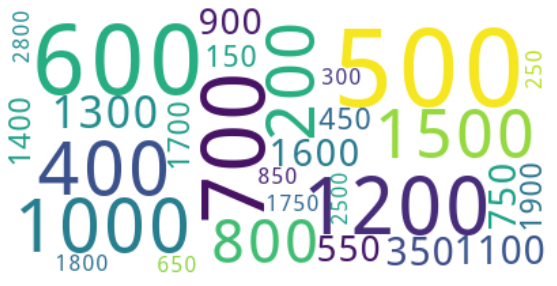

In [135]:
# Creating word_cloud with text as argument in .generate_from_frequencies() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate_from_frequencies(cost_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Collections'*** 

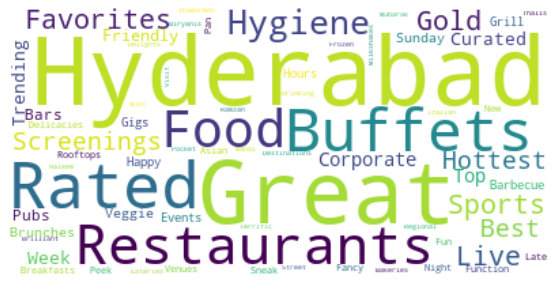

In [136]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(collections_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Cuisines'***

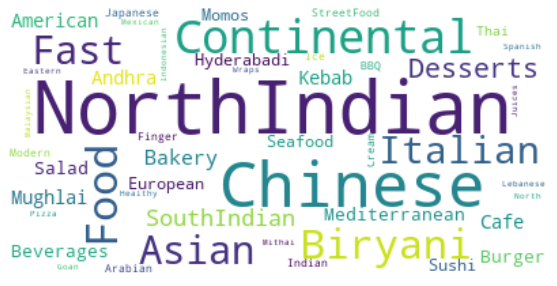

In [137]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(cuisines_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### <b> Feature Engineering

#### Clustering is based on similarity which is measured using distance, so it is necessary to have numerical(continuous) columns so as to quantify distance and compute similarity. Let's engineer such features.

In [138]:
# encoded collections
l1 = list(unique_count['Collections'])
c1_dict = {}
for i,j in enumerate(l1):
  c1_dict[j] = i+1

df1['encoded collections'] = copy.deepcopy(df1['Collections'].values)
for k in df1['encoded collections']:
  for l,m in enumerate(k):
    if str(m)[0] == ' ':
      k[l] = c1_dict[str(m)[1:]]
    else:
      k[l] = c1_dict[m]

In [139]:
# encoded cuisines
l2 = list(unique_count['Cuisines'])
c2_dict = {}
for i,j in enumerate(l2):
  c2_dict[j] = i+1

df1['encoded cuisines'] = copy.deepcopy(df1['Cuisines'].values)
for k in df1['encoded cuisines']:
  for l,m in enumerate(k):
    if str(m)[0] == ' ':
      k[l] = c2_dict[str(m)[1:]]
    else:
      k[l] = c2_dict[m]

In [140]:
# function that returns the similarity
def similarity(m, n):
  cl = []
  for i in m:
    sum = 0
    for j in i:
      if j in m[n]:
        sum += 100
    cl.append(sum)
  return cl

In [141]:
# collections quantified
collections_value = similarity(df1['encoded collections'],0)
for i in range(1, len(df1['encoded collections'])):
  to_add = similarity(df1['encoded collections'],i)
  collections_value = list(map(add, collections_value, to_add))

In [142]:
# cuisines quantified
cuisines_value = similarity(df1['encoded cuisines'],0)
for i in range(1, len(df1['encoded cuisines'])):
  to_add = similarity(df1['encoded cuisines'],i)
  cuisines_value = list(map(add, cuisines_value, to_add))

In [143]:
# create new features for clustering
df1['collections similarity'] = collections_value
df1['collections similarity'][df1['collections similarity'] == 5400] = 0
df1['cuisines similarity'] = cuisines_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
# clean the feature 'Timings'
to_process = []
for l,i in enumerate(df1['Timings']):
  ap = []
  c = 0
  for k,j in enumerate(i):
    if j in ['a', 'p'] and j not in ap:
      c = 1
      ap.append(j)
    elif j == '.' and c == 1:
      if i[k-2] != ' ':
        if l not in to_process:
          to_process.append(l)
    else:
      c += 1
  ap = []
for m in to_process:
  df1['Timings'][m] = df1['Timings'][m].replace('a', ' '+'a')
  df1['Timings'][m] = df1['Timings'][m].replace('p', ' '+'p')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [145]:
# function to extract time
def without_days(d):
  time = ''
  append = 1
  for i in d:
    if i == '(':
      append = 0
    if append == 1:
      time += i
    if i == ')':
      append = 1
  return time

In [146]:
# create new encoded feature of 'Timings 
df1['encoded timings'] = copy.deepcopy(df1['Timings'].values)
df1['encoded timings'] = df1['Timings'].apply(lambda x: without_days(x))
df1['encoded timings'] = df1['encoded timings'].apply(lambda x: x.split(','))

In [147]:
# remove unwanted spaces the feature values
for i in range(len(df1['encoded timings'])):
  for j in range(len(df1['encoded timings'][i])):
    df1['encoded timings'][i][j] = df1['encoded timings'][i][j].strip()

In [148]:
# treat special cases with a different approach
l = [20,26,72,95]
for i in l:
  df1['encoded timings'][i] = df1['encoded timings'][i][:-1]
df1['encoded timings'][30] = ['1 a.m. to 12 p.m.']
df1['encoded timings'][53] = df1['encoded timings'][53][0:2]
df1['encoded timings'][91] = ['1 a.m. to 12 p.m.']
df1['encoded timings'][92] = ['1 a.m. to 12 p.m.']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

In [149]:
# function to extract time as list values
def time(t):
  time_list = []
  empty_list = []
  for a in range(len(t)):
    i = t[a].find('t')

    empty_list.append(t[a][:i-1])
    empty_list.append(t[a][i+3:])
    time_list.append(list(empty_list))
    empty_list = []
    return time_list

In [150]:
# call the time function on encoded values
df1['encoded timings'] = df1['encoded timings'].apply(lambda x: time(x))

In [151]:
# creature a dictionary of encoded values
time_dict = {}
for i in range(1,13):
  time_dict[str(i)+' a.m.'] = i
  time_dict[str(i)+':30'+' a.m.'] = i+0.5
  time_dict[str(i)+' p.m.'] = i+12
  time_dict[str(i)+':30'+' p.m.'] = i+12+0.5
time_dict['12 a.m.'] = 0
time_dict['12 p.m.'] = 12
time_dict['12:30 a.m.'] = 0.5
time_dict['10:40 p.m.'] = 22.65
time_dict['6:45 p.m.'] = 18.75
time_dict['11:55 a.m.'] = 11.95
time_dict['11:15 p.m.'] = 23.25

In [152]:
# encode the values of 'Timings' as per the encoded dict
for k in range(len(df1['encoded timings'])): 
  for i in range(len(df1['encoded timings'][k])):
    for j in range(len(df1['encoded timings'][k][i])):
      df1['encoded timings'][k][i][j] = time_dict[df1['encoded timings'][k][i][j]]  

In [153]:
# logic to create a list of encoded values to call in range function
for j in range(len(df1['encoded timings'])):
  for i in range(len(df1['encoded timings'][j])):
    if df1['encoded timings'][j][i][0] >= 12:
      first = df1['encoded timings'][j][i][0]
      next = df1['encoded timings'][j][i][1]
      df1['encoded timings'][j] = [[first,24],[0,next]]
    if df1['encoded timings'][j][i][0] < 12:
      first = df1['encoded timings'][j][i][0]
      next = df1['encoded timings'][j][i][1]
      df1['encoded timings'][j] = [[first,12],[12,next]]
for j in range(len(df1['encoded timings'])):
  for i in range(len(df1['encoded timings'][j])):
    if df1['encoded timings'][j][i][0] > df1['encoded timings'][j][i][1]:
      first = df1['encoded timings'][j][i][0]
      next = df1['encoded timings'][j][i][1]
      if next <= 12:
        df1['encoded timings'][j] = [[first,12],[12,24],[0,next]]
      if next > 12:
        df1['encoded timings'][j] = [[first,12],[12,next]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipy

In [154]:
# use range to extract all values in between 
for j in range(len(df1['encoded timings'])):
  for i in range(len(df1['encoded timings'][j])):
    df1['encoded timings'][j][i] = list(range(int(df1['encoded timings'][j][i][0]), int(df1['encoded timings'][j][i][1])))

In [155]:
# update the final list of encoded timings
for k in range(len(df1['encoded timings'])):
  final_list = []
  for i in range(len(df1['encoded timings'][k])):
    for j in df1['encoded timings'][k][i]:
      if j not in final_list:
        final_list.append(j)
  df1['encoded timings'][k] = final_list
  final_list = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
# get similarity scores by calling the similarity function
timings_similarity = similarity(df1['encoded timings'],0)
for i in range(1, len(df1['encoded timings'])):
  to_add = similarity(df1['encoded timings'],i)
  timings_similarity = list(map(add, timings_similarity, to_add))
df1['timings similarity'] = timings_similarity

In [157]:
# overview of refined dataset
data_table.disable_dataframe_formatter()
df1.head()

,Name,Cost,Collections,Cuisines,Timings,encoded collections,encoded cuisines,collections similarity,cuisines similarity,encoded timings,timings similarity
0,Beyond Flavours,800,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",4200,14400,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",166500
1,Paradise,800,[Hyderabad's Hottest],"[Biryani, North Indian, Chinese]",11 a.m. to 11 p.m.,[7],"[7, 6, 1]",700,12000,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]",111500
2,Flechazo,1300,"[Great Buffets, Hyderabad's Hottest]","[Asian, Mediterranean, North Indian, Desserts]","11:30 a.m. to 4:30 p.m., 6:30 p.m. to 11 p.m.","[3, 7]","[8, 9, 6, 10]",1800,9400,"[11, 12, 13, 14, 15]",45500
3,Shah Ghouse Hotel & Restaurant,800,[Late Night Restaurants],"[Biryani, North Indian, Chinese, Seafood, ...",12 p.m. to 2 a.m.,[8],"[7, 6, 1, 11, 12]",200,12900,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",122200
4,Over The Moon Brew Company,1200,"[Best Bars & Pubs, Food Hygiene Rated Restaur...","[Asian, Continental, North Indian, Chinese,...","12 p.m. to 11 p.m. (Mon, Tue, Wed, Thu, Sun), ...","[9, 1, 4, 5, 7]","[8, 2, 6, 1, 9]",2900,14500,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",166500


# <u> Clustering Implementation

### <b> K-means Clustering

In [158]:
# Silhouette score
scaler = MinMaxScaler()
df1[['Cost', 'collections similarity', 'cuisines similarity', 'timings similarity']] = scaler.fit_transform(df1[['Cost', 'collections similarity', 'cuisines similarity', 'timings similarity']])
features = ['Cost', 'collections similarity']
X = df1[features].values
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5713470370418322
For n_clusters = 3, silhouette score is 0.5757716906414043
For n_clusters = 4, silhouette score is 0.5049490941071373
For n_clusters = 5, silhouette score is 0.44242221296471546
For n_clusters = 6, silhouette score is 0.4589106305370568
For n_clusters = 7, silhouette score is 0.44990287240370425
For n_clusters = 8, silhouette score is 0.4902854343666384
For n_clusters = 9, silhouette score is 0.4941312289635141
For n_clusters = 10, silhouette score is 0.48099394779373944
For n_clusters = 11, silhouette score is 0.47697547551215064
For n_clusters = 12, silhouette score is 0.4794909175291522
For n_clusters = 13, silhouette score is 0.5009328504350707
For n_clusters = 14, silhouette score is 0.4784443999589447
For n_clusters = 15, silhouette score is 0.47816626774210225


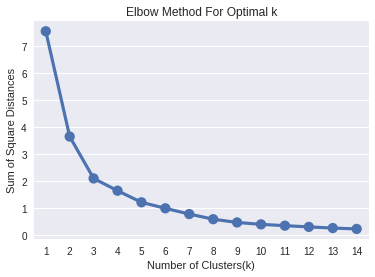

In [159]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [160]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

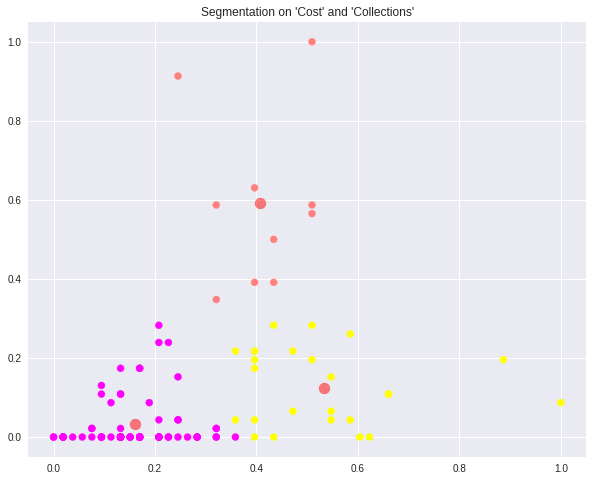

In [161]:
plt.figure(figsize=(10,8))
plt.title("Segmentation on 'Cost' and 'Collections'")
plt.scatter(df1['Cost'], df1['collections similarity'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.5)

In [162]:
features = ['Cost', 'cuisines similarity']
X = df1[features].values
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4881479582802596
For n_clusters = 3, silhouette score is 0.465468714694259
For n_clusters = 4, silhouette score is 0.4548725168436242
For n_clusters = 5, silhouette score is 0.4767567171395527
For n_clusters = 6, silhouette score is 0.47484185628229075
For n_clusters = 7, silhouette score is 0.448946507679106
For n_clusters = 8, silhouette score is 0.43168890329674414
For n_clusters = 9, silhouette score is 0.4036316834146741
For n_clusters = 10, silhouette score is 0.40751923986317995
For n_clusters = 11, silhouette score is 0.3899140973720027
For n_clusters = 12, silhouette score is 0.397536542161104
For n_clusters = 13, silhouette score is 0.411272604744549
For n_clusters = 14, silhouette score is 0.40586484764829517
For n_clusters = 15, silhouette score is 0.3869834809559975


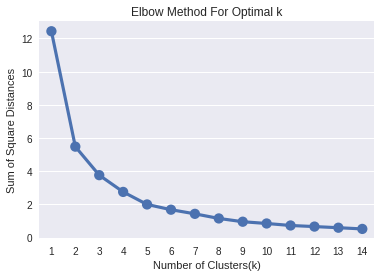

In [163]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [164]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

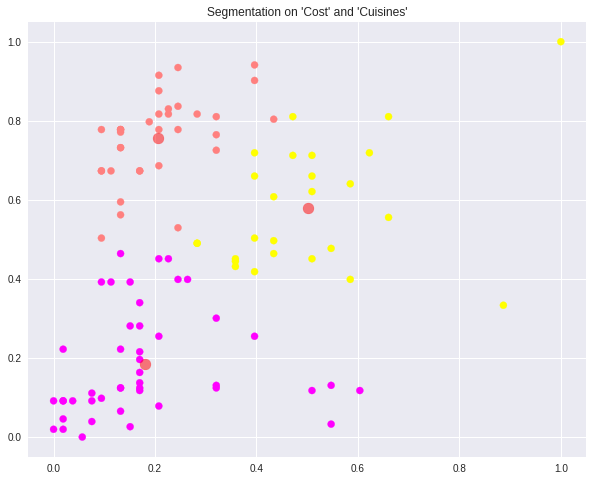

In [165]:
plt.figure(figsize=(10,8))
plt.title("Segmentation on 'Cost' and 'Cuisines'")
plt.scatter(df1['Cost'], df1['cuisines similarity'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


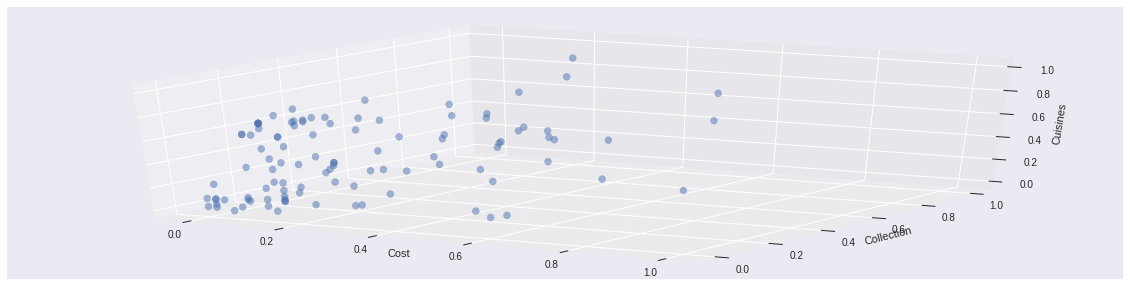

In [166]:
# 3D visualization 
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(20,5))
plt.title('3d visualization of Cost, Collections and Cuisines')
ax=fig.add_subplot(111,projection='3d')
xs=df1['Cost']
ys=df1['collections similarity']
zs=df1['cuisines similarity']
ax.scatter(xs,ys,zs,s=50,alpha=0.5)
ax.set_xlabel('Cost')
ax.set_ylabel('Collection')
ax.set_zlabel('Cuisines')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.41604430560827255
For n_clusters = 3 The average silhouette_score is : 0.3999023844551345
For n_clusters = 4 The average silhouette_score is : 0.4163176965196534
For n_clusters = 5 The average silhouette_score is : 0.40799447524988736
For n_clusters = 6 The average silhouette_score is : 0.42873686320178583
For n_clusters = 7 The average silhouette_score is : 0.4380976643593193
For n_clusters = 8 The average silhouette_score is : 0.42816183111513456
For n_clusters = 9 The average silhouette_score is : 0.4077432358541486
For n_clusters = 10 The average silhouette_score is : 0.377108193533982


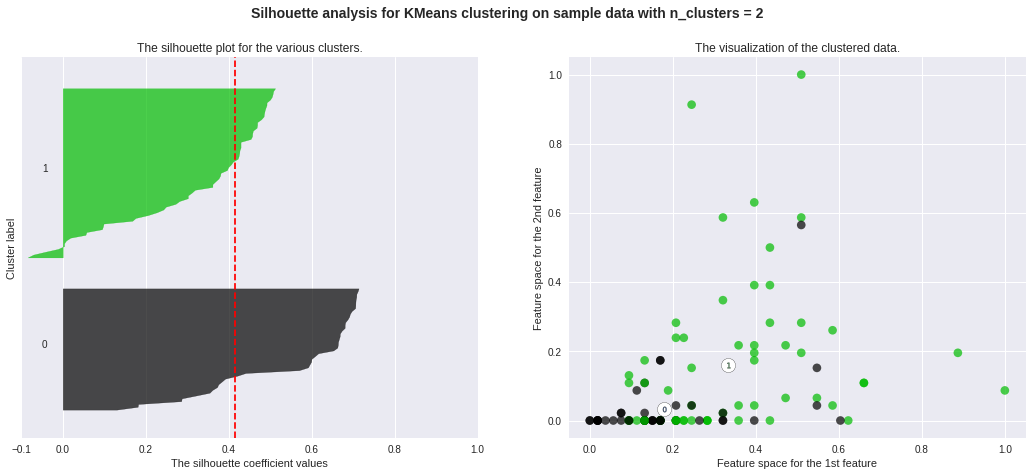

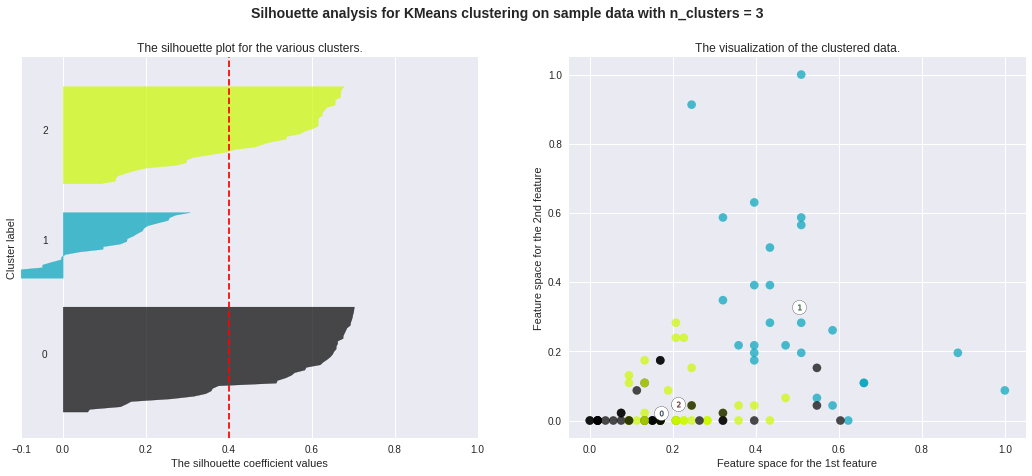

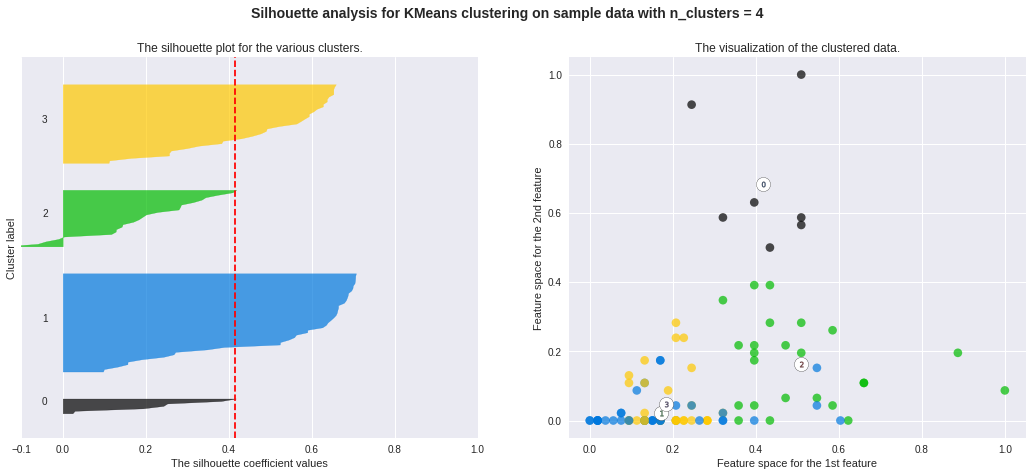

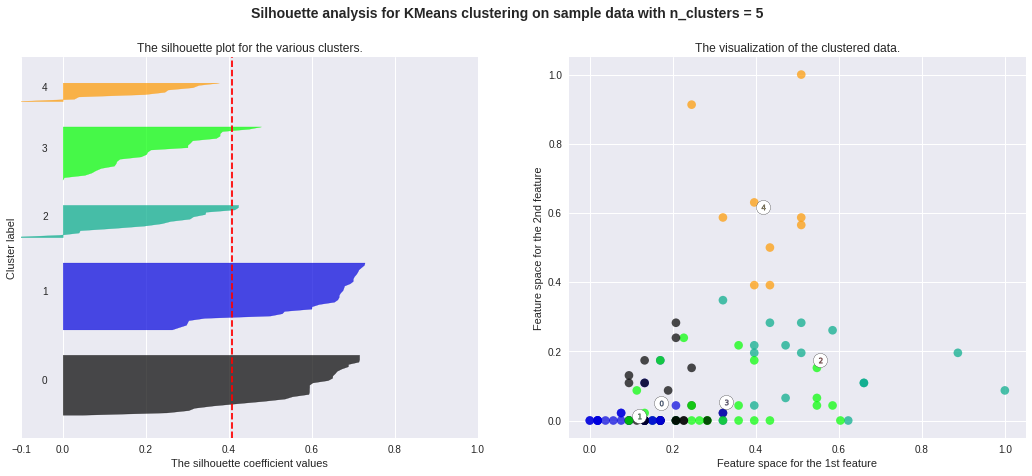

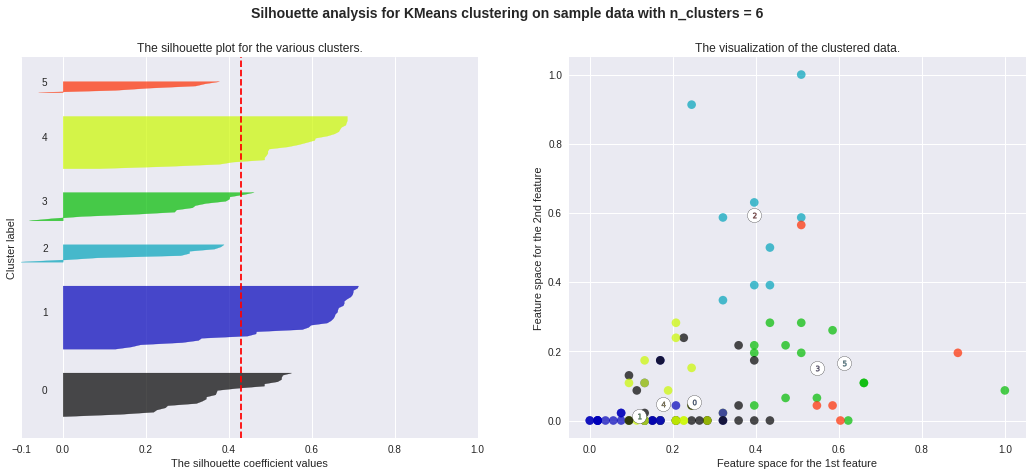

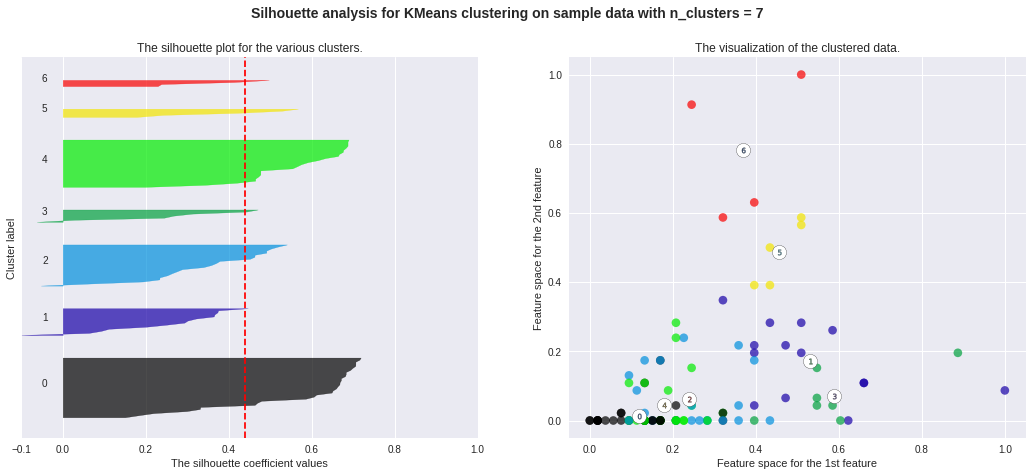

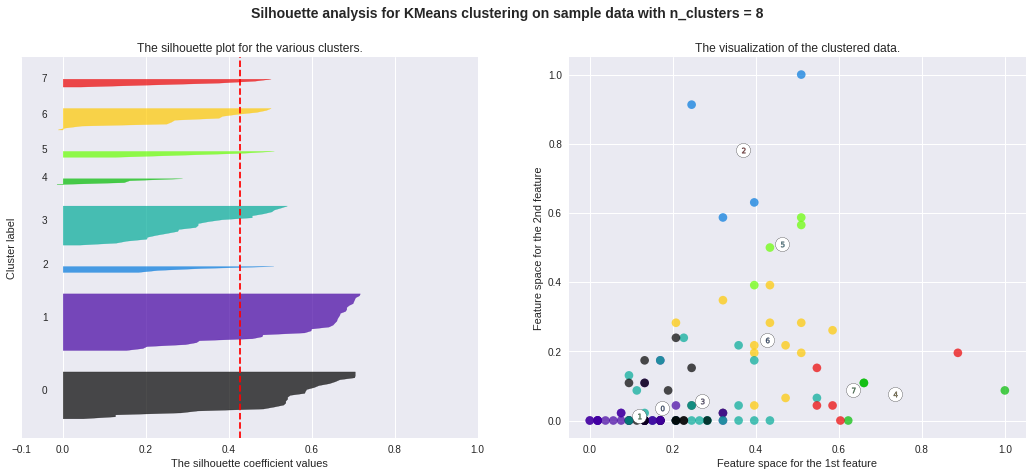

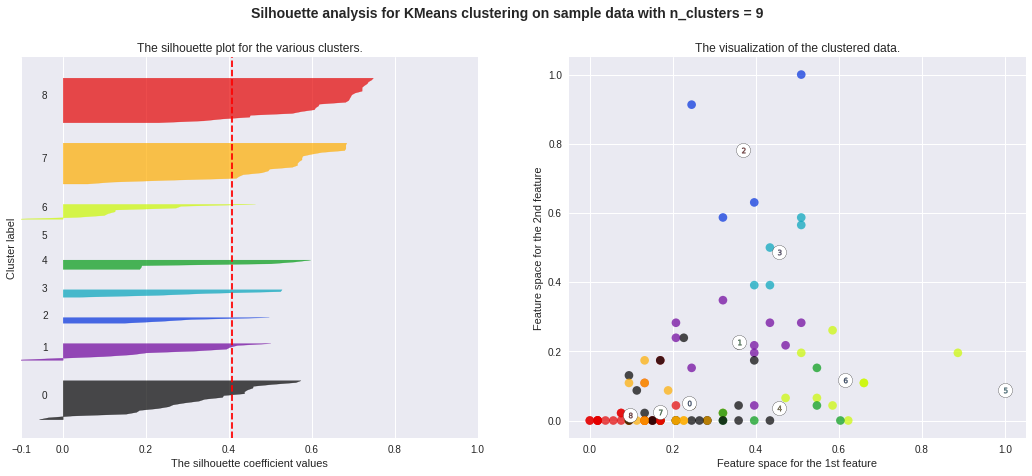

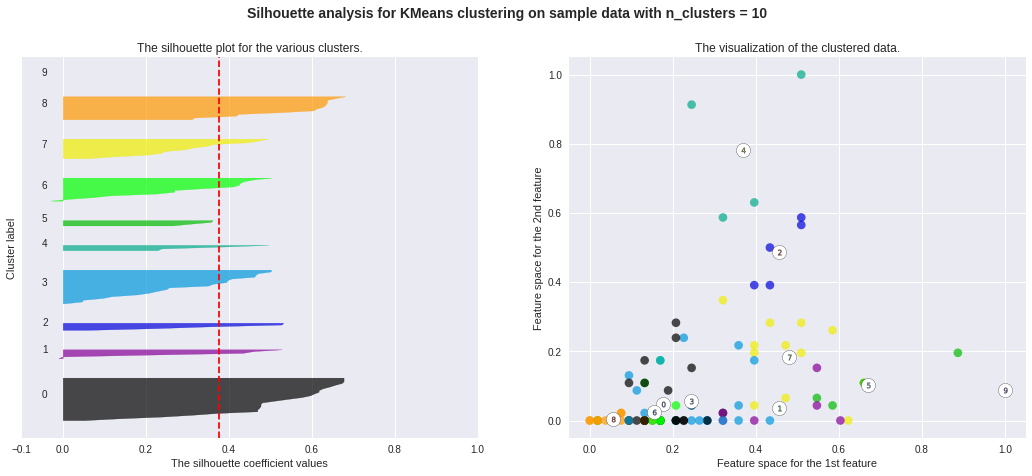

In [167]:
features = ['Cost', 'collections similarity', 'cuisines similarity']
X = df1[features].values

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) /n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=30, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### <b> Hierarchical Clustering

#### <b> Clustering by dining cost of the restaurants

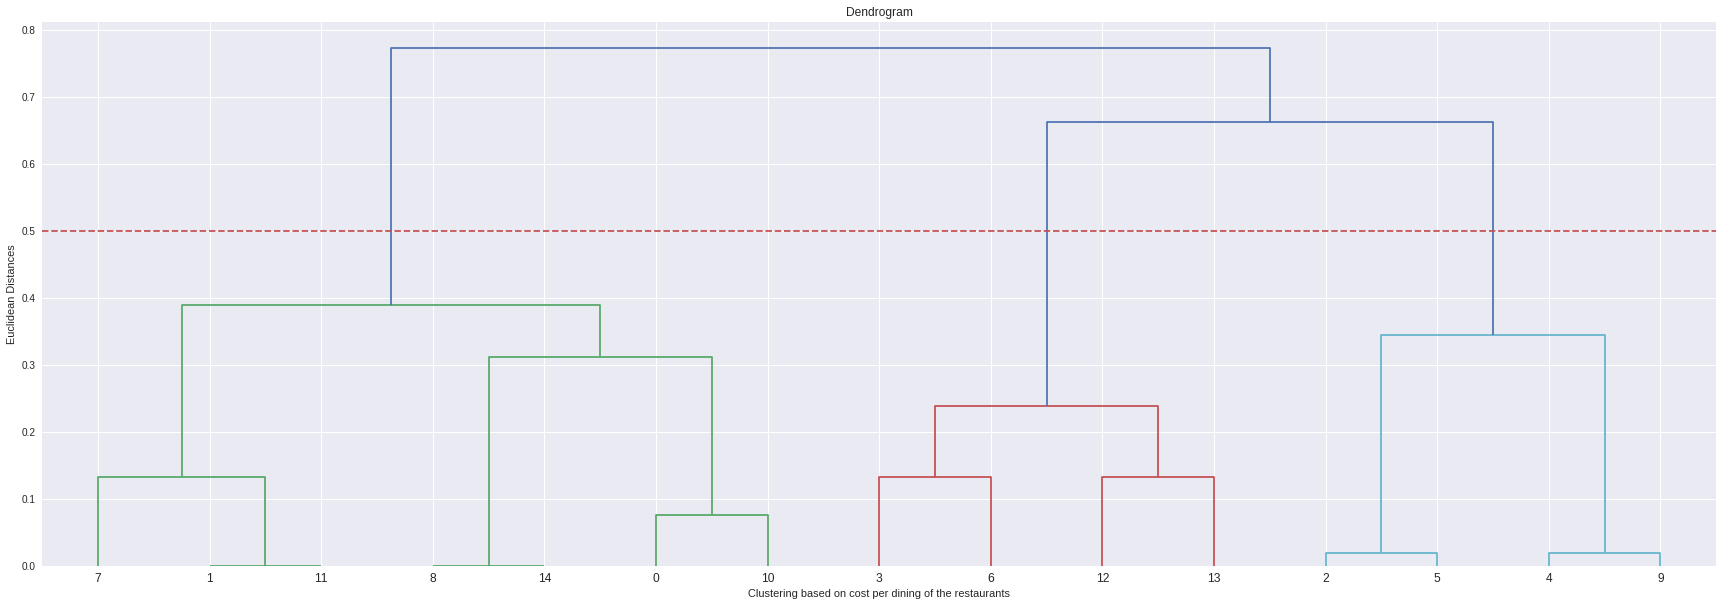

In [168]:
# Plot dendrogram
plt.figure(figsize=(30,10))
dendrogram = sch.dendrogram(sch.linkage(df1['Cost'], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Clustering based on cost per dining of the restaurants')
plt.ylabel('Euclidean Distances')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [169]:
# predict the cluster to which a restaurant falls under
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df1['Cost'].values.reshape(-1,1))

array([1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 0,
       1, 2, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0])

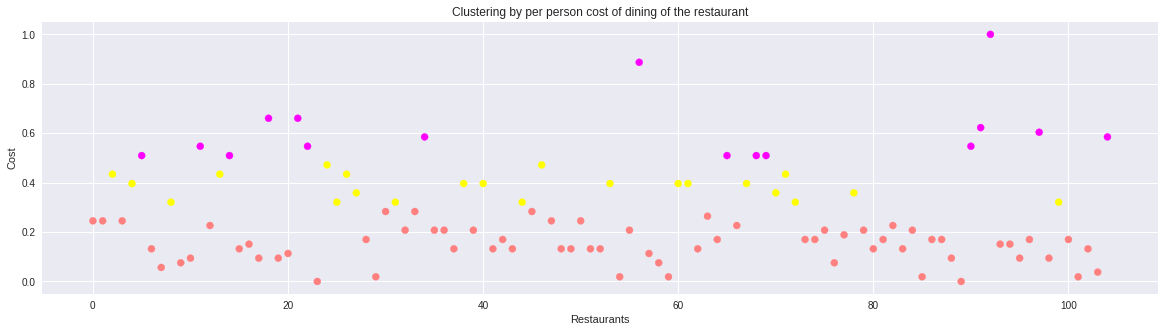

In [170]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(range(105), df1['Cost'], c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title('Clustering by per person cost of dining of the restaurant')
plt.xlabel('Restaurants')
plt.ylabel('Cost')
plt.show()

#### <b> Cost vs Benefit Analysis

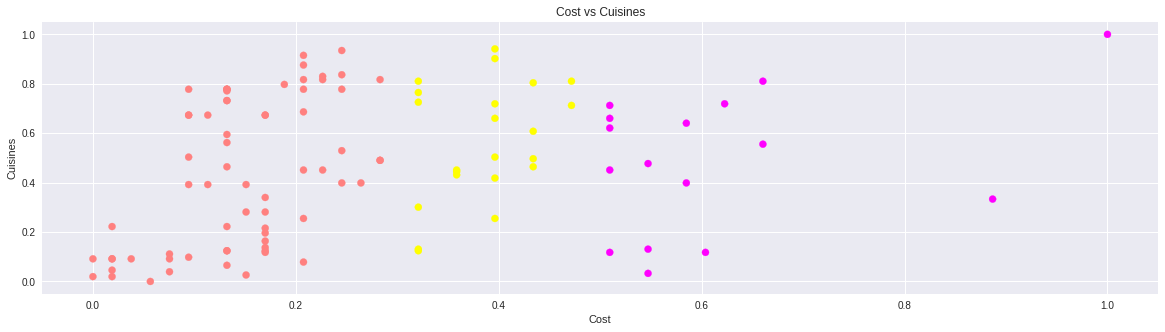

In [171]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(df1['Cost'], df1['cuisines similarity'], c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title('Cost vs Cuisines')
plt.xlabel('Cost')
plt.ylabel('Cuisines')
plt.show()

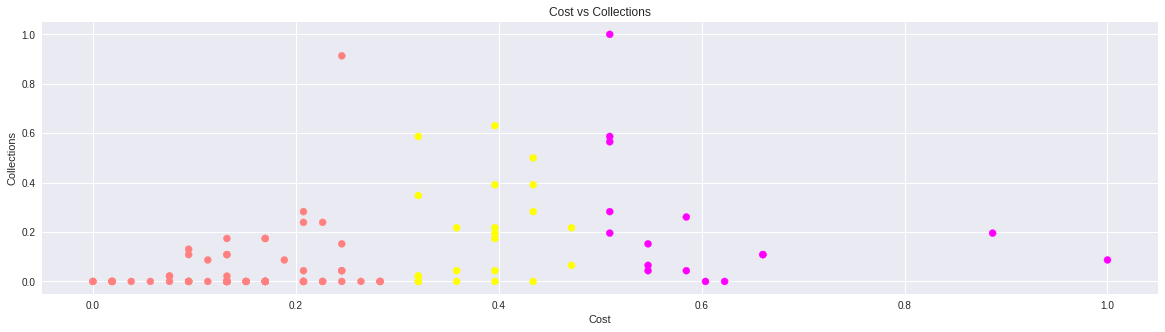

In [172]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(df1['Cost'], df1['collections similarity'], c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title('Cost vs Collections')
plt.xlabel('Cost')
plt.ylabel('Collections')
plt.show()

#### <b> Clustering by collections of the restaurants 

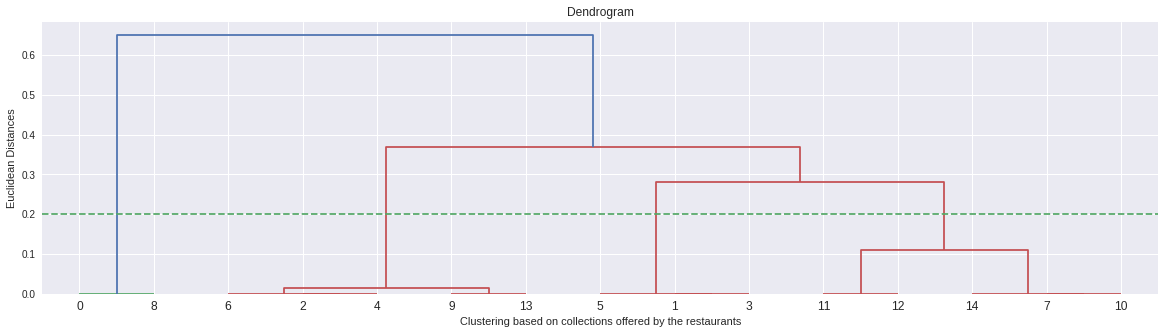

In [173]:
# Plot dendrogram
plt.figure(figsize=(20,5))
dendrogram = sch.dendrogram(sch.linkage(df1['collections similarity'], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Clustering based on collections offered by the restaurants')
plt.ylabel('Euclidean Distances')
plt.axhline(y=0.2, color='g', linestyle='--')
plt.show()

In [174]:
# predict the cluster to which a restaurant falls under
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df1['collections similarity'].values.reshape(-1,1))

array([0, 1, 1, 2, 0, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1,
       2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

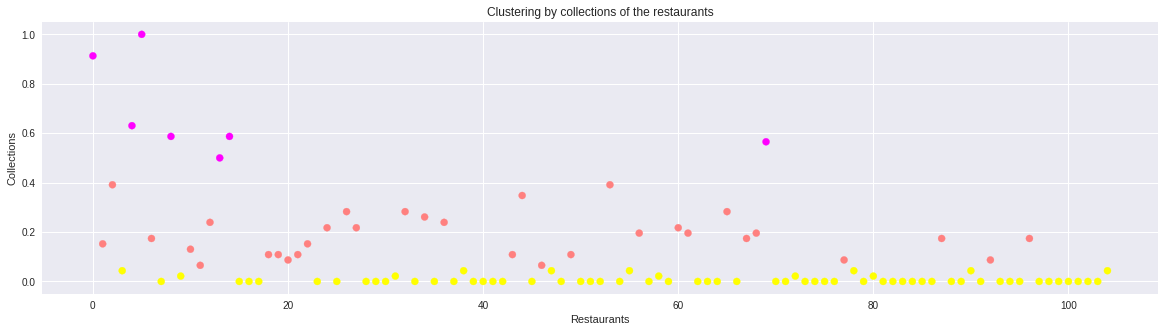

In [175]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(range(105), df1['collections similarity'], c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title('Clustering by collections of the restaurants')
plt.xlabel('Restaurants')
plt.ylabel('Collections')
plt.show()

#### <b> Clustering by cuisines offered by the restaurants

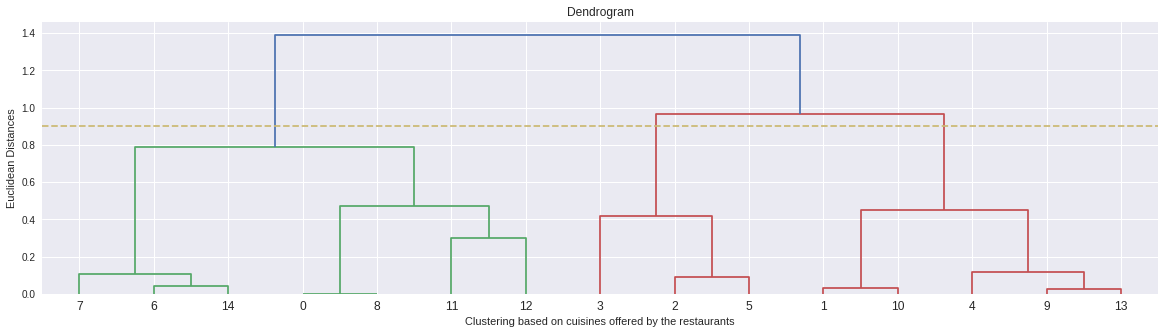

In [176]:
# Plot dendrogram
plt.figure(figsize=(20,5))
dendrogram = sch.dendrogram(sch.linkage(df1['cuisines similarity'], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Clustering based on cuisines offered by the restaurants')
plt.ylabel('Euclidean Distances')
plt.axhline(y=0.9, linestyle='--', color='y')
plt.show()

In [177]:
# predict the cluster to which a restaurant falls under
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df1['cuisines similarity'].values.reshape(-1,1))

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 2])

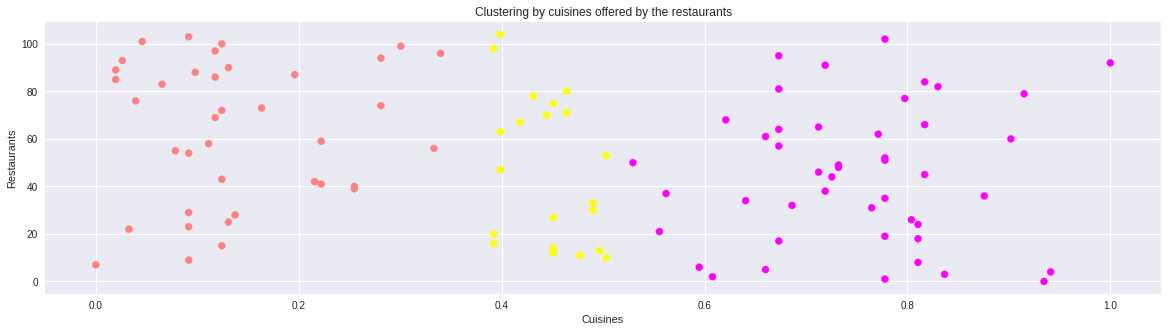

In [178]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(df1['cuisines similarity'], range(105), c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title('Clustering by cuisines offered by the restaurants')
plt.xlabel('Cuisines')
plt.ylabel('Restaurants')
plt.show()

#### <b> Clustering by operating times of the restaurants

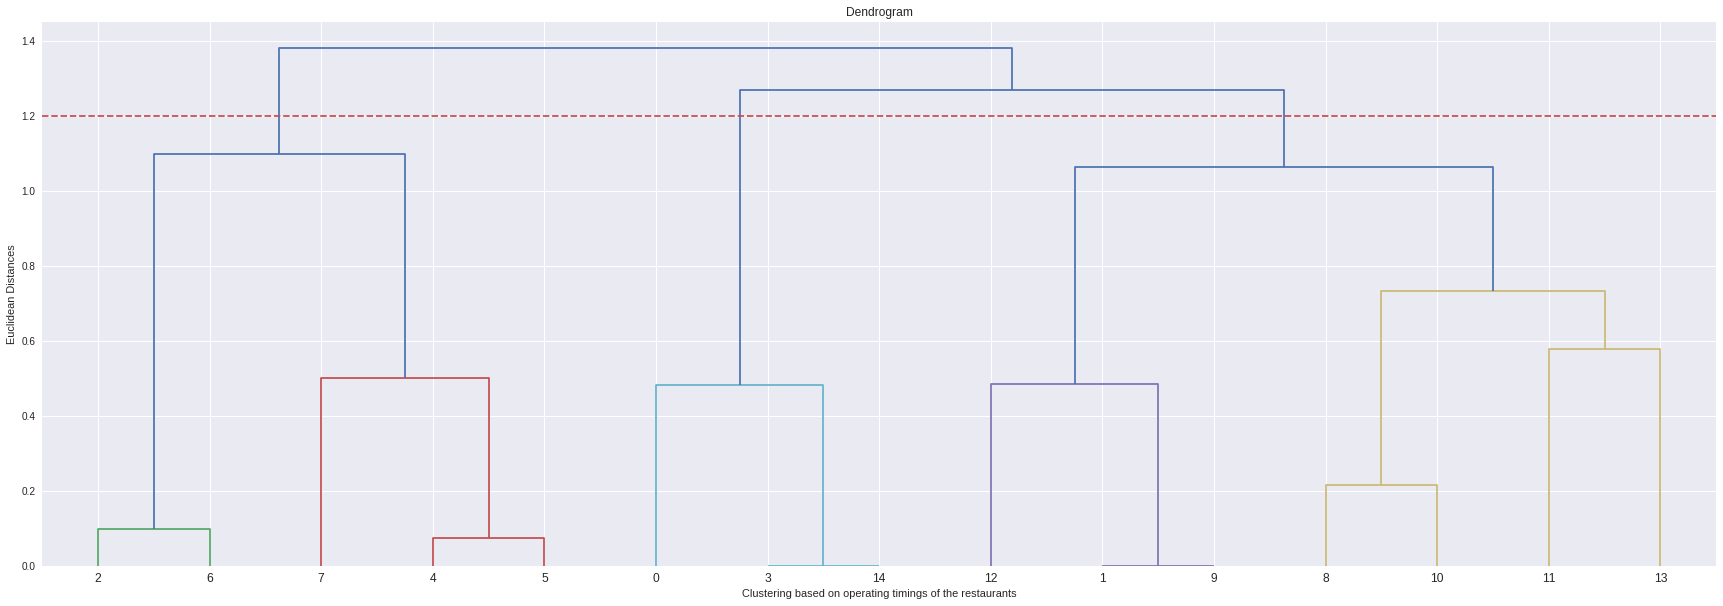

In [179]:
# Plot dendrogram
plt.figure(figsize=(30,10))
dendrogram = sch.dendrogram(sch.linkage(df1['timings similarity'], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Clustering based on operating timings of the restaurants')
plt.ylabel('Euclidean Distances')
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

In [180]:
# predict the cluster to which a restaurant falls under
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df1['timings similarity'].values.reshape(-1,1))

array([1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 0,
       2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0])

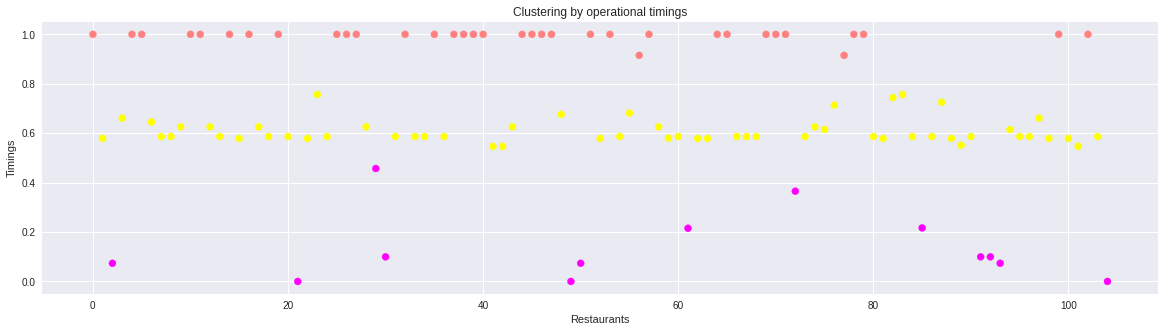

In [181]:
# visualize the clusters
plt.figure(figsize=(20, 5))  
plt.scatter(range(105), df1['timings similarity'], c=cluster.labels_, s=50, cmap='spring', alpha=1) 
plt.title("Clustering by operational timings")
plt.xlabel("Restaurants")
plt.ylabel("Timings")
plt.show()

# **Sentiment Analysis**

In [182]:
df2.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [183]:
# rename column for merge
df2.rename(columns={'Restaurant':'Name'}, inplace=True)

In [184]:
# merge datasets
df = pd.merge(df1, df2, how='inner', on='Name')

In [185]:
df.head()

,Name,Cost,Collections,Cuisines,Timings,encoded collections,encoded cuisines,collections similarity,cuisines similarity,encoded timings,timings similarity,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,0.245283,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",0.913043,0.934641,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",1.0,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,0.245283,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",0.913043,0.934641,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",1.0,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,0.245283,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",0.913043,0.934641,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",1.0,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,0.245283,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",0.913043,0.934641,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",1.0,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,0.245283,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12 p.m. to 3:30 p.m., 6:30 p.m. to 11:30 p.m. ...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",0.913043,0.934641,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",1.0,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    10000 non-null  object 
 1   Cost                    10000 non-null  float64
 2   Collections             10000 non-null  object 
 3   Cuisines                10000 non-null  object 
 4   Timings                 10000 non-null  object 
 5   encoded collections     10000 non-null  object 
 6   encoded cuisines        10000 non-null  object 
 7   collections similarity  10000 non-null  float64
 8   cuisines similarity     10000 non-null  float64
 9   encoded timings         10000 non-null  object 
 10  timings similarity      10000 non-null  float64
 11  Reviewer                9962 non-null   object 
 12  Review                  9955 non-null   object 
 13  Rating                  9962 non-null   object 
 14  Metadata                9962 non-null  

In [187]:
# drop null values
df.dropna(axis=0, inplace=True)
df = df.drop(df[df['Rating']=='Like'].index, axis = 0)
df.reset_index(inplace=True)
df = df.drop('index', axis=1)

In [188]:
# extract review and followers from metadata
df['Metadata'] = df['Metadata'].apply(lambda x: x.split(' '))
df['Reviews'] = df['Metadata'].apply(lambda x: x[0])
df['followers'] = df['Metadata'].apply(lambda x: x[-2])

# cast to appropriate datatype
df['Reviews'] = df['Reviews'].astype(int)
df['followers'] = df['followers'].astype(int)

In [189]:
# indexes with high reviews and followers
r = df.iloc[list(df['Reviews'][df['Reviews'].isin(sorted(df['Reviews'], reverse=True)[:120])].index),11].unique()
f = df.iloc[list(df['followers'][df['followers'].isin(sorted(df['followers'],reverse=True)[:120])].index),11].unique()

# list of critics
critics = []
for i in r:
  if i in list(f):
    critics.append(i)
critics

['Asad Rana',
 'Ramesh Menon',
 'Paramita Sarkar',
 'Epicurean Tales',
 'Mithun Ravindranathan',
 'Kamaal Ahmed (zaiqebaaz)',
 'Supriya Subudhi',
 'Sumit',
 'Abhilash Pradhan (AbTheFoodie)',
 'Yash Kumar Singh',
 'Anjan Goswami',
 'Aarti Kamath',
 'Sabyasachi Raychaudhuri',
 'Nitin Shiralkar']

In [190]:
# remove punctuations from reviews
translator = str.maketrans('', '', string.punctuation)
df['review'] = copy.deepcopy(df['Review'])
df['review'] = df['review'].apply(lambda x: x.translate(translator))

In [191]:
# remove stopwords from reviews
sw = stopwords.words('english')
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)
df['review'] = df['review'].apply(stopwords)

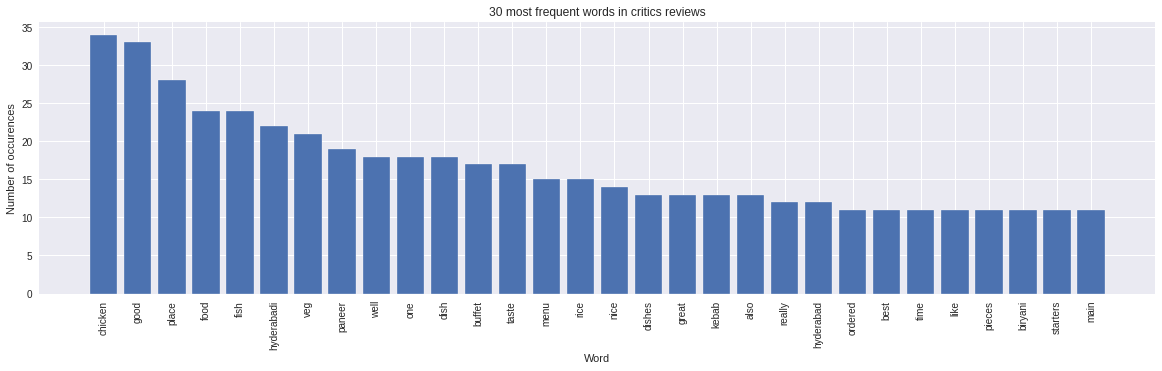

In [192]:
# vectorize the critics reviews
count_vectorizer = CountVectorizer()
vectorized_reviews = count_vectorizer.fit_transform(df[df['Reviewer'].isin(critics)]['review'].values)
vectorized_total = np.sum(vectorized_reviews, axis=0)
word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
word_values = np.flip(np.sort(vectorized_total)[0,:],1)

# words vectorized
word_vectors = np.zeros((30, vectorized_reviews.shape[1]))
for i in range(30):
  word_vectors[i,word_indices[0,i]] = 1

# frequent words with frequency of occurance
words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]
word_values = word_values[0,:30].tolist()[0]

# plotting 30 most frequent words
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('30 most frequent words in critics reviews')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

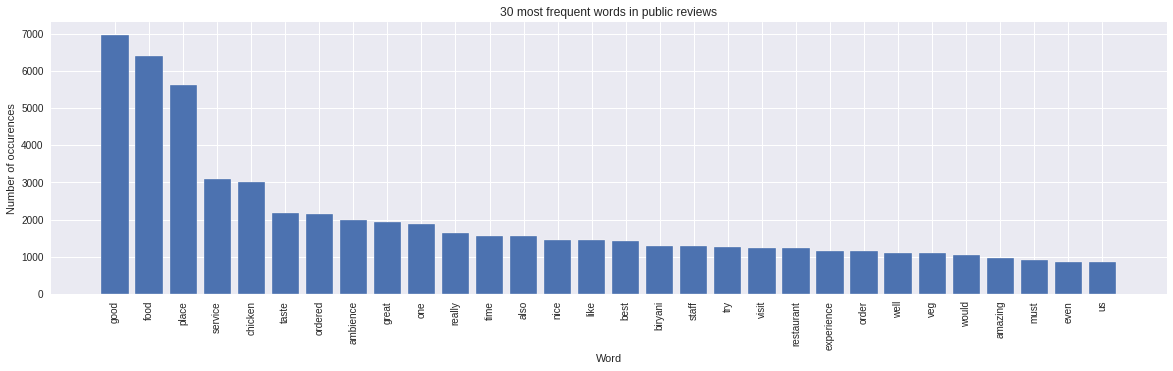

In [193]:
# vectorize the public reviews
count_vectorizer = CountVectorizer()
vectorized_reviews = count_vectorizer.fit_transform(df[~df['Reviewer'].isin(critics)]['review'].values)
vectorized_total = np.sum(vectorized_reviews, axis=0)
word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
word_values = np.flip(np.sort(vectorized_total)[0,:],1)

# words vectorized
word_vectors = np.zeros((30, vectorized_reviews.shape[1]))
for i in range(30):
  word_vectors[i,word_indices[0,i]] = 1

# frequent words with frequency of occurance
words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]
word_values = word_values[0,:30].tolist()[0]

# plotting 30 most frequent words
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('30 most frequent words in public reviews')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [194]:
# function to give the sentiment of a review
def sentiment(x):
  if x < 3:
    return -1
  elif x >= 3 and x < 4:
    return 0
  else:
    return 1

In [195]:
#Adding the sentiments column
df['Rating'] = df['Rating'].astype(float)
df['sentiment'] = df.Rating.apply(lambda x: sentiment(x))

In [196]:
# select independent variable and D.V
X = df['Review']
y = df['sentiment']

# split dataset for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.5, random_state=0)

In [197]:
# vectorize the reviews
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# implementing logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_vec, y_train)
lr_score = lr.score(X_test_vec, y_test)
y_pred_lr = lr.predict(X_test_vec)
print("Results for Logistic Regression with tfidf")
print(lr_score)

Results for Logistic Regression with tfidf
0.8316254771950975


In [198]:
# function to give the sentiment of a review
def sentiment(x):
  if x == 1:
    return 'positive'
  elif x == -1:
    return 'negative'
  else:
    return 'neutral'

In [199]:
# dataframe with reviews and its sentiment
sentiment_df = pd.DataFrame(data={'review':X_test, 'predictions':y_pred_lr, 'actuals':y_test})
sentiment_df['predicted sentiment'] = sentiment_df['predictions'].apply(lambda x: sentiment(x))
sentiment_df['actual sentiment'] = sentiment_df['actuals'].apply(lambda x: sentiment(x))

In [200]:
# view and compare predictions
sentiment_df_sample = sentiment_df[:100]
data_table.DataTable(sentiment_df_sample, include_index=False, num_rows_per_page=25)

,review,predictions,actuals,predicted sentiment,actual sentiment
6403,I love to eat biryani in Hyderabad Chefs.Food ...,1,1,positive,positive
3161,Biryani is worst....No A/C...But the prices ar...,-1,-1,negative,negative
1382,"Even though this place is huge, we couldn't fi...",1,1,positive,positive
3240,Been to this place after looking at the rating...,1,0,positive,neutral
6820,Amazing atmosphere and beautifully designed ba...,1,1,positive,positive
2043,The best place to have authentic Punjabi food ...,1,1,positive,positive
1091,If you crave for some Mumbai style chaat then ...,1,1,positive,positive
7028,Firstly my cocktail was messed up and than pan...,-1,-1,negative,negative
6661,Very tasty biryani,1,1,positive,positive
8188,food was not good as before. Salt was less in ...,-1,-1,negative,negative


In [202]:
# dataframe with sentiments data 
l1 = ['positive', 'negative', 'neutral']
l2 = list(sentiment_df['predicted sentiment'].value_counts())
l3 = list(sentiment_df['actual sentiment'].value_counts())
l4 = ['predicted']*3 + ['actual']*3
df_bar = pd.DataFrame(data={'type':l4, 'sentiment':l1+l1, 'predictions':l2+l3})

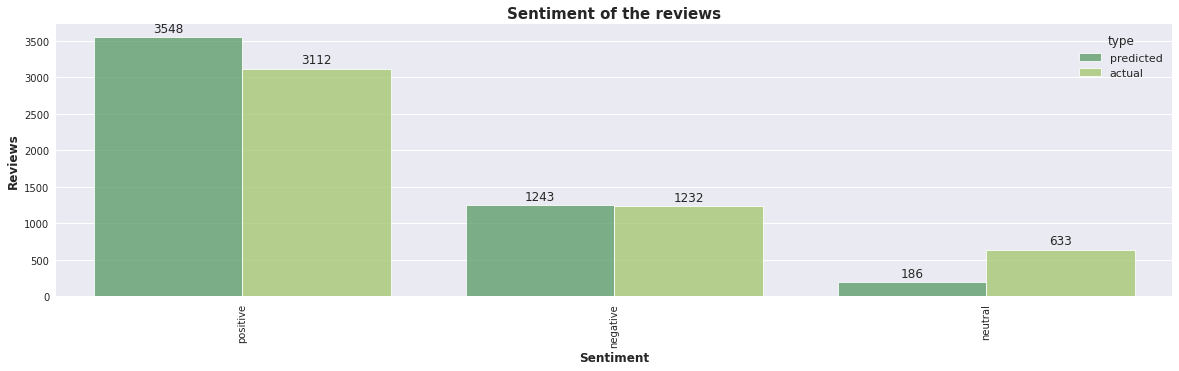

In [203]:
# visualize the sentiments in reviews
f, ax = plt.subplots(1,1, figsize=(20,5))
sns.set_theme(style="white")
splot = sns.barplot(x=df_bar['sentiment'], y=df_bar['predictions'], hue=df_bar['type'], alpha=0.8, palette='summer')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Sentiment of the reviews',weight='bold', size=15)
plt.ylabel('Reviews', size=12, weight='bold')
plt.xlabel('Sentiment', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()


In [204]:
# evaluate the predictions
print(f'confusion matrix \n{confusion_matrix(y_test, y_pred_lr)}\n')
print(f'classification report \n{classification_report(y_test, y_pred_lr)}')

confusion matrix 
[[1040   51  141]
 [ 137   94  402]
 [  66   41 3005]]

classification report 
              precision    recall  f1-score   support

          -1       0.84      0.84      0.84      1232
           0       0.51      0.15      0.23       633
           1       0.85      0.97      0.90      3112

    accuracy                           0.83      4977
   macro avg       0.73      0.65      0.66      4977
weighted avg       0.80      0.83      0.80      4977



### <b> Conclusion

*   We started with dataset inspection and found presence of nan values which was replaced with a string, unusable columns were droped and strings were formatted to be similar.
*   Exploratory data analysis was carried out on the dataset and various insights from the features cost, collections and cuisines were obtained.
*   Numerical features that represent the categorical features were engineered to compute distance which was used as the similarity metric to cluster the restaurants.
*   Clustering on restaurants was performed using K-means clustering and Hierarchical clustering (Agglomerative). The clusters were also used to get useful information like cost-benefit analysis.
*   Sentiment Analysis was done on the reviews of the restaurants using multinomial logistic regression. Critics were identified. Appropriate visualizations were used to derive insights.



